In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #RMSE = sqrt(MSE)
from sklearn.preprocessing import StandardScaler

#Ансамбли методов для задачи регрессии

##Предобработка данных

In [ ]:
car_dataframe = pd.read_csv('car_details_from_car_dekho_preprocessed.csv')

In [ ]:
car_dataframe = car_dataframe#.sample(frac = 1)
car_dataframe.head(5)

name  year  selling_price  km_driven  fuel  seller_type  transmission  \
0    12  2007          60000      70000     3            2             1   
1    12  2007         135000      50000     3            2             1   
2    27  2012         600000     100000     2            2             1   
3     7  2017         250000      46000     3            2             1   
4    19  2014         450000     141000     2            2             1   

   owner  
0      1  
1      1  
2      1  
3      1  
4      2

In [ ]:
car_dataframe.describe() #из результатов вывода функции describe можно сделать вывод, что среди вещественных признаков анормальным
# является только значение пробега автомобиля

name         year  selling_price      km_driven         fuel  \
count  4340.000000  4340.000000   4.340000e+03    4340.000000  4340.000000   
mean     15.321659  2013.090783   5.041273e+05   66215.777419     2.481106   
std       8.162825     4.215344   5.785487e+05   46644.102194     0.562206   
min       0.000000  1992.000000   2.000000e+04       1.000000     0.000000   
25%      12.000000  2011.000000   2.087498e+05   35000.000000     2.000000   
50%      12.000000  2014.000000   3.500000e+05   60000.000000     2.000000   
75%      22.000000  2016.000000   6.000000e+05   90000.000000     3.000000   
max      28.000000  2020.000000   8.900000e+06  806599.000000     4.000000   

       seller_type  transmission        owner  
count  4340.000000   4340.000000  4340.000000  
mean      1.518433      0.896774     1.447005  
std       0.841361      0.304289     0.712191  
min       0.000000      0.000000     0.000000  
25%       1.000000      1.000000     1.000000  
50%       2.000000      1.000000     1.000000  
75%       2.000000      1.000000     2.000000  
max       2.000000      1.000000     4.000000

In [ ]:
Q_1 = {} #объявляем словари для минимального и максимального значения
Q_3 = {}
for elem in car_dataframe.describe().drop(columns=['selling_price', 'name', 'owner', 'transmission', 'seller_type', 'fuel', 'year']).columns:
  Q_1[elem] = car_dataframe.describe().iloc[4][elem] #записываем в словарь значения первого квартиля
  Q_3[elem] = car_dataframe.describe().iloc[6][elem] #записываем в словарь значения третьего квартиля

In [ ]:
for elem in car_dataframe.describe().drop(columns=['selling_price', 'name', 'owner', 'transmission', 'seller_type', 'fuel', 'year']).columns:
  car_dataframe = car_dataframe[car_dataframe[elem] < (Q_3[elem] + (0.5 * Q_3[elem]))]
  car_dataframe = car_dataframe[car_dataframe[elem] > (Q_1[elem] - (0.5 * Q_1[elem]))]

In [ ]:
car_dataframe.describe()

name         year  selling_price      km_driven         fuel  \
count  3630.000000  3630.000000   3.630000e+03    3630.000000  3630.000000   
mean     15.460606  2012.713499   4.708472e+05   65246.789532     2.476033   
std       8.054613     4.138749   5.224659e+05   29475.580872     0.564255   
min       0.000000  1992.000000   2.000000e+04   17563.000000     0.000000   
25%      12.000000  2010.000000   1.950000e+05   40000.000000     2.000000   
50%      12.000000  2013.000000   3.250000e+05   60000.000000     2.000000   
75%      22.000000  2016.000000   5.787500e+05   89705.750000     3.000000   
max      28.000000  2020.000000   5.500000e+06  134444.000000     4.000000   

       seller_type  transmission        owner  
count  3630.000000   3630.000000  3630.000000  
mean      1.524793      0.905785     1.468320  
std       0.838793      0.292168     0.708539  
min       0.000000      0.000000     0.000000  
25%       2.000000      1.000000     1.000000  
50%       2.000000      1.000000     1.000000  
75%       2.000000      1.000000     2.000000  
max       2.000000      1.000000     4.000000

##Разбиение выборки на обучающую и тестовую; основные функции-инструменты

In [ ]:
X = car_dataframe.drop(columns = ['selling_price'])
y = car_dataframe['selling_price']

In [ ]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=car_dataframe.shape[0])
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
Loss = ({'model' : [], 'test_R2' : [], 'test_MAE' :[] , 'test_MSE' :[], 'test_RMSE' :[], 'hyper_params' : []}) #заводим пустой датафрейм для хранения показателей метрик качества моделей линейной регрессии
df_Loss = pd.DataFrame(Loss)

In [ ]:
def metrics_of_quality(model, y_test, y_pred, params, df):  # функция для оценки качества обученной модели
  te_r2 = r2_score(y_test, y_pred).round(4)
  te_MAE = mean_absolute_error(y_test, y_pred).round(4)
  te_MSE = mean_squared_error(y_test, y_pred).round(4)
  te_RMSE = np.sqrt(te_MSE).round(4)
  new_row = {'model' : str(model), 'test_R2' : te_r2, 'test_MAE' : te_MAE, 'test_MSE' : te_MSE, 'test_RMSE' : te_RMSE, 'hyper_params' : params}
  df = df.append(new_row, ignore_index = True)
  return df

## Регрессия

In [ ]:
from catboost import CatBoostRegressor, Pool
cat = CatBoostRegressor()
cat.fit(X_train,y_train,verbose=False, plot=True)
y_pred_regressor = cat.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
df_Loss = metrics_of_quality("CatBoostRegressor", y_test, y_pred_regressor, '', df_Loss) 

In [ ]:
df_Loss

model  test_R2    test_MAE      test_MSE    test_RMSE  \
0  CatBoostRegressor   0.7957  127463.959  6.244371e+10  249887.3982   

  hyper_params  
0

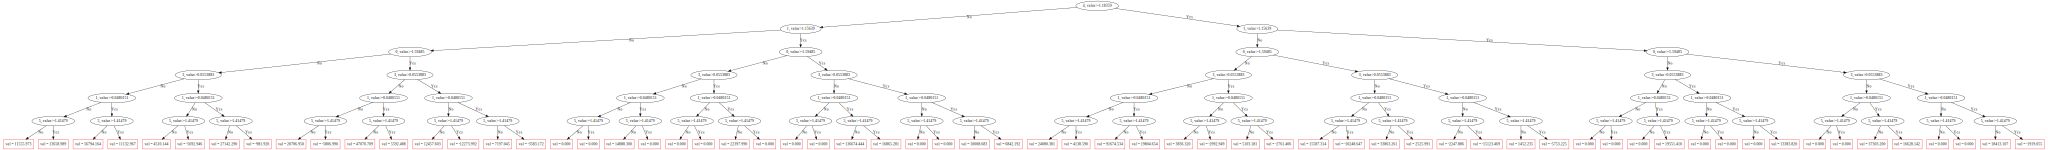

In [ ]:
cat.plot_tree(tree_idx=0)

#Ансамбли методов для задачи классификации

##Предобработка данных 

In [ ]:
water_dataframe = pd.read_csv('water_potability_preprocessed.csv')

In [ ]:
water_dataframe = water_dataframe.drop(columns = ['Unnamed: 0'])
water_dataframe.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  3276.000000  3276.000000   3276.000000  3276.000000  3276.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.469956    32.879761   8768.570828     1.583085    36.142612   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.277673   176.850538  15666.690297     6.127421   317.094638   
50%       7.080795   196.967627  20927.833607     7.130299   333.775777   
75%       7.870050   216.667456  27332.762127     8.114887   350.385756   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3276.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        15.769881     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        56.647656     3.439711     0.000000  
50%      421.884968       14.218338        66.396293     3.955028     0.000000  
75%      481.792304       16.557652        76.666609     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [ ]:
Loss = ({'model' : [], 'test_accuracy' : [], 'test_recall' :[] , 'test_AUC' :[], 'test_precision' : [], 'hyper_params' : []}) 
df_Loss_Cl = pd.DataFrame(Loss)

In [ ]:
Q_1 = {} #объявляем словари для минимального и максимального значения
Q_3 = {}
for elem in water_dataframe.describe().drop(columns=['Potability']).columns:
  Q_1[elem] = water_dataframe.describe().iloc[4][elem] #записываем в словарь значения первого квартиля
  Q_3[elem] = water_dataframe.describe().iloc[6][elem] #записываем в словарь значения третьего квартиля

In [ ]:
for elem in water_dataframe.describe().drop(columns=['Potability']).columns:
  water_dataframe = water_dataframe[water_dataframe[elem] < (Q_3[elem] + (0.5 * Q_3[elem]))]
  water_dataframe = water_dataframe[water_dataframe[elem] > (Q_1[elem] - (0.5 * Q_1[elem]))]

In [ ]:
X = water_dataframe.drop(columns = ['Potability'])
y = water_dataframe['Potability']

In [ ]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=car_dataframe.shape[0])
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

def loss_func_classifier(df, model, y_test, y_pred, params):  # функция для оценки качества обученной модели
  te_ac = accuracy_score(y_test, y_pred).round(4)
  te_rec = recall_score(y_test, y_pred).round(4)
  te_prec = precision_score(y_test, y_pred).round(4)
  te_auc = roc_auc_score(y_test, y_pred).round(4)
  new_row = {'model' : model, 'test_accuracy' : te_ac, 'test_recall' : te_rec, 'test_AUC' : te_auc, 'test_precision' : te_prec, 'hyper_params' : params}
  df = df.append(new_row, ignore_index = True)
  return df

## Классификация

In [ ]:
from catboost import CatBoostClassifier
cat_class = CatBoostClassifier()
cat_class.fit(X_train,y_train,verbose=False, plot=True)
y_pred_classifier = cat_class.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
df_Loss_Cl = loss_func_classifier(df_Loss_Cl, "CatBoostClass", y_test, y_pred_classifier, '')

In [ ]:
df_Loss_Cl

model  test_accuracy  test_recall  test_AUC  test_precision  \
0  CatBoostClass         0.6711       0.3262    0.5986          0.5944   

  hyper_params  
0

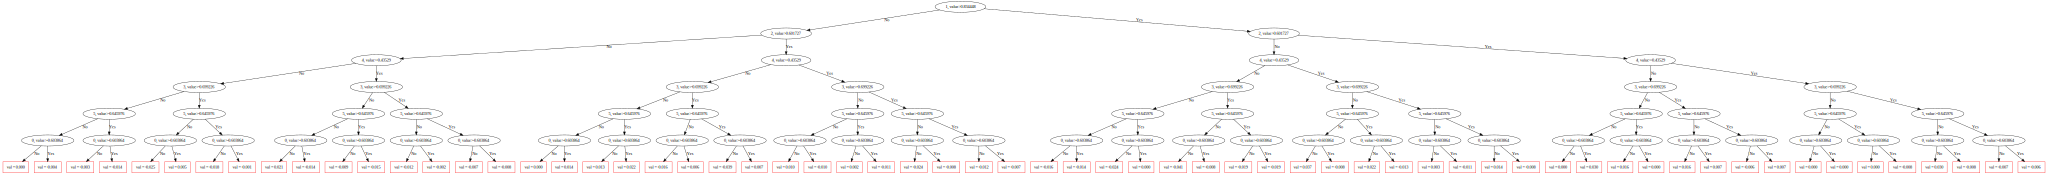

In [ ]:
cat_class.plot_tree(tree_idx=0)